In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import glob
import pickle
import time
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
import math
from sklearn.base import clone
!pip install scikit-optimize
from skopt import gp_minimize
!pip install hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval

In [2]:
# calendar_dfs = []
# for file_name in glob.glob('./data/amsterdam/calendar*.gz'):
#     calendar_dfs.append(pd.read_csv(file_name, compression='gzip'))
# calendar = pd.concat(calendar_dfs, sort=True)

In [3]:
# reviews_dfs = []
# for file_name in glob.glob('./data/amsterdam/reviews*.gz'):
#     reviews_dfs.append(pd.read_csv(file_name, compression='gzip'))
# reviews = pd.concat(reviews_dfs, sort=True)

In [4]:
# listings_dfs = []
# for file_name in glob.glob('./data/amsterdam/listings*.gz'):
#     listings_dfs.append(pd.read_csv(file_name, compression='gzip', dtype="str"))
# listings = pd.concat(listings_dfs, sort=True)

## Data Preparation

In [5]:
calendar = pd.read_csv("./data/boston/calendar.csv")
reviews = pd.read_csv("./data/boston/reviews.csv")
listings = pd.read_csv("./data/boston/listings.csv")

### Transforming 'price' from string to numeric

In [6]:
"""
    Converts price in the string format like "$1,125.00" into numeric value 1125.00
    INPUT:
    - string price in string format
    OUTPUT:
    - float value corresponding to the price or None if the input is not parseable to float
"""
def str_to_num (string):
    if string is not None:
        if type(string) is str and string.startswith('$'):
            return float(string.replace('$', '').replace(',', ''))
        else:
            return None
    else:
        return None
listings_cleaned = pd.concat([listings.drop('price', axis=1), listings["price"].apply(str_to_num)], axis=1)
listings_cleaned['price'].head()

0    250.0
1     65.0
2     65.0
3     75.0
4     79.0
Name: price, dtype: float64

In [7]:
calendar_cleaned = pd.concat([calendar.drop('price', axis=1), calendar["price"].apply(str_to_num)], axis=1)
calendar_cleaned['price'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: price, dtype: float64

### Converting 'avilable' field from string to binary

In [8]:
calendar_cleaned['available'] = calendar_cleaned['available'] == 't'
calendar_cleaned['available'].head()

0    False
1    False
2    False
3    False
4    False
Name: available, dtype: bool

### Converting 'date' from string to datetime format

In [9]:
calendar_cleaned["date"] = pd.to_datetime(calendar_cleaned["date"], format="%Y-%m-%d")

### Converting location field from numeric to categorical

In [10]:
listings_cleaned["location_categorical"] = listings_cleaned.apply(lambda row: str((format(row.latitude, '.2f'), format(row.longitude, '.2f'))), axis=1)

In [11]:
listings_cleaned.location_categorical.head()

0    ('42.28', '-71.13')
1    ('42.29', '-71.13')
2    ('42.29', '-71.14')
3    ('42.28', '-71.12')
4    ('42.28', '-71.14')
Name: location_categorical, dtype: object

### Converting 'amenities' field containing list into separate categorical columns for each amenity in dataframe

In [12]:
list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), listings_cleaned.amenities.iloc[0].split(",")))

['TV',
 'Wireless Internet',
 'Kitchen',
 'Free Parking on Premises',
 'Pets live on this property',
 'Dog(s)',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Smoke Detector',
 'Fire Extinguisher',
 'Essentials',
 'Shampoo',
 'Laptop Friendly Workspace']

In [13]:
"""
    Separates the string value of `amenities` attribute in the row, into a list of individual amenities.
    
    INPUT:
    - row : from dataset having amenities attribute
    OUTPUT:    
    - list of amenities derived from the value of `amenities` attribute in row
"""
def separate_amenities(row):
    amenities = row.amenities
    list_to_return = []
    if (amenities is not None and type(amenities) == str):            
        list_to_return = list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), amenities.split(",")))
    if '' in list_to_return:
        list_to_return.remove('')
    return list_to_return
listings_cleaned["amenities_list"] = listings_cleaned.apply(separate_amenities, axis=1)

In [14]:
possible_amenities = listings_cleaned['amenities_list'].apply(pd.Series).stack().unique()
possible_amenities

array(['TV', 'Wireless Internet', 'Kitchen', 'Free Parking on Premises',
       'Pets live on this property', 'Dog(s)', 'Heating',
       'Family/Kid Friendly', 'Washer', 'Dryer', 'Smoke Detector',
       'Fire Extinguisher', 'Essentials', 'Shampoo',
       'Laptop Friendly Workspace', 'Internet', 'Air Conditioning',
       'Pets Allowed', 'Carbon Monoxide Detector', 'Lock on Bedroom Door',
       'Hangers', 'Hair Dryer', 'Iron', 'Cable TV', 'First Aid Kit',
       'Safety Card', 'translation missing: en.hosting_amenity_49',
       'translation missing: en.hosting_amenity_50', 'Gym', 'Breakfast',
       'Indoor Fireplace', 'Cat(s)', '24-Hour Check-in', 'Hot Tub',
       'Buzzer/Wireless Intercom', 'Other pet(s)', 'Washer / Dryer',
       'Smoking Allowed', 'Suitable for Events', 'Wheelchair Accessible',
       'Elevator in Building', 'Pool', 'Doorman',
       'Paid Parking Off Premises', 'Free Parking on Street'],
      dtype=object)

In [15]:
"""
    Assigns new boolean attribute to the row based on the presence of that amenity in the list.
    Returns updated row with additional attributes corresponding to the amenities added to it.
    
    INPUT:
    - row containing attributes related to the property, including `amenities_list`
    OUTPUT:
    - row containing newly added boolean attributes indicating the presence of each possible type of amenity in the property
"""
def add_amenities_columns (row):
    amenities = set(row.amenities_list)
    for possible_amenity in possible_amenities:
        row["amenity_" + possible_amenity] = possible_amenity in amenities
    return row

listings_cleaned = listings_cleaned.apply(add_amenities_columns, axis=1)

### Identifying the activation date for each property listing

In [16]:
df = calendar_cleaned
df = df.groupby('listing_id', group_keys=False)\
    .apply(lambda x: x[x.available.ne(x.available.shift())])\
    .reset_index(drop=True)
df.head(20)

,listing_id,date,available,price
0,3353,2017-09-05,True,36.0
1,3353,2016-12-30,False,NaN
2,3353,2017-08-18,True,36.0
3,3353,2016-10-12,False,NaN
4,5506,2017-09-05,True,145.0
5,5506,2016-10-10,False,NaN
6,5506,2016-10-03,True,145.0
7,5506,2016-09-30,False,NaN
8,5506,2016-09-28,True,145.0
9,5506,2016-09-25,False,NaN


In [17]:
listing_activation_dates = df[df.available == True].groupby("listing_id")[["listing_id","date"]].min()

In [18]:
listing_activation_dates.sort_values(by=["date"]).head()

,listing_id,date
listing_id,,
530983,530983,2016-09-06
815639,815639,2016-09-06
12726343,12726343,2016-09-06
2776391,2776391,2016-09-06
10524612,10524612,2016-09-06


### Only retaining entries in calendar for each property after its activation date

In [19]:
cal_by_listing_groups = calendar_cleaned.groupby(["listing_id"])

In [20]:
cal_by_listing_groups.head()

,listing_id,date,available,price
0,12147973,2017-09-05,False,NaN
1,12147973,2017-09-04,False,NaN
2,12147973,2017-09-03,False,NaN
3,12147973,2017-09-02,False,NaN
4,12147973,2017-09-01,False,NaN
365,3075044,2017-08-22,True,65.0
366,3075044,2017-08-21,True,65.0
367,3075044,2017-08-20,True,65.0
368,3075044,2017-08-19,True,75.0
369,3075044,2017-08-18,True,75.0


In [21]:
def select_entries_after_activation_date(g):

    listing_id = g.name
    activation_date_df = listing_activation_dates.query("listing_id == @listing_id")["date"]
    if activation_date_df.shape[0] > 0:        
        activation_date = activation_date_df.iloc[0]
#         print("activatation_date: " + str(activation_date))
#         print(g["date"].dtype)
#         print(type(activation_date))
        return g[g["date"] <= activation_date]
    
    
cal_after_activation_dates =cal_by_listing_groups.apply(select_entries_after_activation_date)

### Select and add necessary variables to be used for predicting occupancy of property at given time of the year

In [176]:
input_vars_from_listings = ["neighbourhood_cleansed", 
#                 "neighbourhood_group_cleansed",
                "city",
                "state",
                "zipcode",
                "market",
                "location_categorical",
                "property_type",
                "room_type",
                "accommodates",
                "bathrooms",
                "bedrooms",
                "beds",
                "bed_type",
                "square_feet",
                "guests_included",
                "minimum_nights",
                "maximum_nights",
                "review_scores_rating",
                "review_scores_accuracy",
                  "review_scores_cleanliness",
                  "review_scores_checkin",
                  "review_scores_communication",
                  "review_scores_location",
                  "review_scores_value",
#                   "jurisdiction_names",
                  "cancellation_policy",
#                   "reviews_per_month",
                  "number_of_reviews"
       ]
amenity_variables = list(map(lambda amenity : "amenity_" + amenity, possible_amenities))
input_vars_from_listings.extend(amenity_variables)


In [177]:
calendar_cleaned["month"] = calendar_cleaned['date'].dt.month_name()

In [178]:
calendar_cleaned["day_of_week"] = calendar_cleaned['date'].dt.weekday_name

In [179]:
calendar_cleaned["week_of_month"] = np.ceil(calendar_cleaned['date'].dt.day/7).astype(int)

In [180]:
calendar_cleaned["week_of_month"].unique()

array([1, 5, 4, 3, 2])

In [181]:
df = pd.merge(listings_cleaned, calendar_cleaned, left_on="id", right_on="listing_id", how="inner", suffixes=("_listings", "_calendar"))

In [182]:
g = df.groupby(["listing_id"]).apply(lambda x: x.sort_values(by=["date"]))

In [183]:
g.loc[:, "price_calendar"] = g["price_calendar"].fillna(method="ffill")

In [184]:
df = g.drop(columns=["listing_id"]).reset_index()

In [185]:
input_vars_from_calendar = ["month", "day_of_week", "week_of_month", "price_calendar"]

In [186]:
all_input_vars = input_vars_from_listings + input_vars_from_calendar;

In [187]:
df = df.dropna(subset=["available"])

In [188]:
X = df[all_input_vars + ["listing_id"]]

In [189]:
y = df[["available"] + ["listing_id"]]

### Fill missing values in numeric columns with mean of the corresponding column

In [190]:
num_vars = X.select_dtypes(exclude=['object']).copy().columns
def fill_mean (col):
    return col.fillna(col.mean())
X.loc[X.index, num_vars] = X[num_vars].apply(fill_mean, axis=0)

### Convert categorical variables into numeric variables with separate column for missing values

In [191]:
cat_vars = X.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)    

### Splitting data into training and test sets while making sure that no property listing is common between them

In [192]:
unique_listing_ids = X["listing_id"].unique()

In [193]:
np.random.seed(42)
listing_ids_train = np.random.choice(np.array(unique_listing_ids), size= int(0.70 * len(unique_listing_ids)), replace=False)
listing_ids_test = [l for l in unique_listing_ids if l not in listing_ids_train]

In [194]:
X_train = X.query("listing_id in @listing_ids_train")
y_train = y.query("listing_id in @listing_ids_train")

In [195]:
X_train.index == y_train.index

array([ True,  True,  True, ...,  True,  True,  True])

I am using here only a smaller sample of training data to choose hyper parameters using cross validation technique to complete the experiments in timely manner. However, in real world scenario with availability of time, higher computational resources and memory, entire training dataset should be used for choosing optimal hyper parameters.

In [196]:
X_train_sample = X_train.sample(10000)
y_train_sample = y.loc[X_train_sample.index]

In [197]:
X_test = X.query("listing_id in @listing_ids_test").drop(columns=["listing_id"])
y_test = y.query("listing_id in @listing_ids_test").drop(columns=["listing_id"])

In [198]:
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [199]:
y_train["available"].value_counts()/y_train.shape[0]

False    0.510366
True     0.489634
Name: available, dtype: float64

Considering the ratio of samples classified for output True and False, the data looks to be balanced.

### Preparing cross validation splits to into training and test sets while making sure that no property listing is common between them

In [43]:
class MyGridSearchCV(object):
    
    def __init__(self, estimator, param_grid, cv=3):
        self.estimator = estimator
        self.param_grid = param_grid
        self.best_score = -math.inf
        self.best_estimator = None
        self.best_estimator_scores_mean = -math.inf
        self.best_estimator_scores_stdev = -math.inf
        self.best_params= None
        self.cv = cv       
    
    def fit(self, X, y):
        for param_point in self.get_param_grid_points():
            def splits(array, k):
                splits = []
                
                for i in range(k):
                    split_length = math.ceil(len(array)/k)
                    split = []
                    for j in range(i * split_length, (i+1) * split_length):
                        if j < len(array):
                            split.append(array[j])
                        
                    splits.append(split)
                cvs = []
                for i, split in enumerate(splits):
                    train = []
                    for j, other_split in enumerate(splits):
                        if i != j:
                            train += other_split
                    test = [] + split
                    cvs.append((train, test))
                return cvs
                    
            scores_for_point = []
            estimator = clone(self.estimator)
            estimator.set_params(**param_point)
            for l_train, l_test in splits(list(X["listing_id"].unique()), k=self.cv):                
                X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
                X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
                y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
                y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])                
                estimator.fit(X_train, y_train.values.ravel())
                y_preds = estimator.predict(X_test)
                f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
                f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
                score = min([f1_score_1, f1_score_0])
                scores_for_point.append(score)
                
            mean_score = np.mean(scores_for_point)
            if mean_score > self.best_estimator_scores_mean:
                self.best_estimator_scores_mean = mean_score
                self.best_estimator_scores_stdev = np.std(scores_for_point)
                self.best_estimator = estimator
                self.best_params = self.best_estimator.get_params()
                self.best_score = self.best_estimator_scores_mean
   
            
    def get_param_grid_points(self):
        points = [{}]
        for param, values in self.param_grid.items():
            new_points = []
            for point in points:
                for value in values:                    
                    new_point = point.copy()
                    new_point[param]= value
                    new_points.append(new_point)
            points = new_points
        return points
    
    def print_best(self):
        print("Best score:")
        print(self.best_score)
        print("Best params:")
        print(self.best_params)
        print("Best estimator scores mean:")
        print(self.best_estimator_scores_mean)
        print("Best estimator scores stdev:")
        print(self.best_estimator_scores_stdev)

In [121]:
def my_cross_val_score(estimator, X, y):
    def splits(array, k):
        splits = []

        for i in range(k):
            split_length = math.ceil(len(array)/k)
            split = []
            for j in range(i * split_length, (i+1) * split_length):
                if j < len(array):
                    split.append(array[j])

            splits.append(split)
        cvs = []
        for i, split in enumerate(splits):
            train = []
            for j, other_split in enumerate(splits):
                if i != j:
                    train += other_split
            test = [] + split
            cvs.append((train, test))
        return cvs

    scores_for_point = []
    for l_train, l_test in splits(list(X["listing_id"].unique()), k=5):                
        X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
        X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
        y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
        y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])                
        estimator.fit(X_train, y_train.values.ravel())
        y_preds = estimator.predict(X_test)
        f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
        f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
        score = min([f1_score_1, f1_score_0])
        scores_for_point.append(score)

    mean_score = np.mean(scores_for_point)
    return mean_score

import decimal

def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step

We are using Bayesian optimization technique for choosing hyper parameters for each classifier. 

Please note that I am choosing the number of points explored in the parameter space to be 100 which can be considered as too small. However, keeping it small is essential to generate results in this notebook in timely manner for demonstration purpose. For real use case, it can be increased to 1000 or 10000 to get most optimal choice of hyperparameters from the hyperparameter space.

### Decision Tree Classifier

Using Bayesian Optimization technique implemented in gp_minimize method of Scikit Optimize package to choose optimal hyper parameters.

In [ ]:
def objective_dtc(params):
    clf = DecisionTreeClassifier(
        max_depth = params[0],
        min_samples_leaf = params[1],
        max_features = params[2],
        min_samples_split = params[3],
        random_state = 42
    )
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    return -score
start_time = time.time()
dtc_opt_result = gp_minimize(
    func=objective_dtc,
    dimensions=[
        (5, 30),
        (1, 10),
        (0.1, 1.0),
        (2, 20)
    ],
    random_state=42
)
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
best_params_list_dtc = dtc_opt_result.x
best_score_dtc = -dtc_opt_result.fun
best_params_dtc = {
    "max_depth": best_params_list_dtc[0],
    "min_samples_leaf": best_params_list_dtc[1],
    "max_features": best_params_list_dtc[2],
    "min_samples_split": best_params_list_dtc[3]
}
print ("Best score: " + str(best_score_dtc))
dtc = DecisionTreeClassifier()
best_params_dtc["random_state"] = 42
dtc.set_params(**best_params_dtc)
dtc.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(dtc, open('dtc_best.pkl', 'wb'))

## Ensemble Learners

### AdaBoost

In [123]:
def objective_ada(params):
    clf = AdaBoostClassifier(DecisionTreeClassifier())
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
ada_param_space = {
    "base_estimator__min_samples_leaf": hp.choice("base_estimator__min_samples_leaf", range(1,6,2)),
    "base_estimator__min_samples_split": hp.choice("base_estimator__min_samples_split", [2*x for x in range(1,11,2)]),
    "base_estimator__max_depth": hp.choice("base_estimator__max_depth", range(5, 31, 5)),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}

best_params_ada = space_eval(ada_param_space, fmin(objective_ada, ada_param_space, algo=tpe.suggest, max_evals=100))
print ("Best params: ")
print (best_params_ada)
ada = AdaBoostClassifier(DecisionTreeClassifier())
ada.set_params(**best_params_ada)
ada.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(ada, open('ada_best.pkl', 'wb'))

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


KeyboardInterrupt: 

### Gradient Boost

Using custom Grid Search Cross validation method implemented by me to choose optimal hyper parameters.

In [118]:
def objective_gb(params):
    clf = GradientBoostingClassifier()
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score

gb_param_space = {    
    "max_depth": hp.choice("max_depth", range(1, 11, 1)),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}

best_params_gb = space_eval(gb_param_space, fmin(objective_gb, gb_param_space, algo=tpe.suggest, max_evals=100))
print ("Best params: ")
print (best_params_gb)
gb = GradientBoostingClassifier()
gb.set_params(**best_params_gb)
gb.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(gb, open('gb_best.pkl', 'wb'))

{'max_depth': 9, 'n_estimators': 60}                 
score: 0.696610497861299                             
{'max_depth': 7, 'n_estimators': 100}                                           
score: 0.6948120679057627                                                       
{'max_depth': 7, 'n_estimators': 60}                                            
score: 0.6932807018941117                                                       
{'max_depth': 1, 'n_estimators': 50}                                            
score: 0.6061870705911634                                                       
{'max_depth': 7, 'n_estimators': 60}                                            
score: 0.6947278164100691                                                     
{'max_depth': 3, 'n_estimators': 90}                                          
score: 0.6725557920558277                                                     
{'max_depth': 4, 'n_estimators': 40}                                          
score: 0.

### Random Forest

In [124]:
def objective_rf(params):
    clf = RandomForestClassifier()
    clf.set_params(**params)
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
rf_param_space = {
    "min_samples_leaf": hp.choice("min_samples_leaf", range(1, 10, 2)),
    "max_depth": hp.choice("max_depth", range(5, 31, 2)),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_rf = space_eval(rf_param_space, fmin(objective_rf, rf_param_space, algo=tpe.suggest, max_evals=100))
print ("Best params: ")
print (best_params_rf)
rf = RandomForestClassifier()
rf.set_params(**best_params_gb)
rf.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(rf, open('rf_best.pkl', 'wb'))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

{'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 42}
score: 0.6852563051659241                            
{'max_depth': 21, 'min_samples_leaf': 1, 'n_estimators': 40, 'random_state': 42}
score: 0.6888692813185899                                                      
{'max_depth': 9, 'min_samples_leaf': 9, 'n_estimators': 80, 'random_state': 42}
score: 0.6667019428150623                                                      
{'max_depth': 13, 'min_samples_leaf': 9, 'n_estimators': 30, 'random_state': 42}
score: 0.6699654945138891                                                      
{'max_depth': 25, 'min_samples_leaf': 3, 'n_estimators': 50, 'random_state': 42}
score: 0.69761761647907                                                        
{'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 80, 'random_state': 42}
score: 0.6382559003697867                                                    
{'max_depth': 19, 'min_samples_leaf': 9, 'n_estimators': 90, 'r

### Prediction & Model Evaluation of Ensemble Learners

In [126]:
models = {
    "Random Forest": "rf_best.pkl",
    "Gradient Boost": "gb_best.pkl",
    "Ada Boost": "ada_best.pkl",
    "Single Decision Tree": "dtc_best.pkl"
}
for model_name in models.keys():
    model_file_name = models[model_name]
    model = pickle.load(open(model_file_name, 'rb'))
    y_preds = model.predict(X_test)
    f1 = f1_score(y_test, y_preds, average="macro")
    print ("Model: " + model_name + " f1-score: " + str(f1))

Model: Random Forest f1-score: 0.6723685549898285
Model: Gradient Boost f1-score: 0.7109701838759012
Model: Ada Boost f1-score: 0.6888888158539574
Model: Single Decision Tree f1-score: 0.6422772986026057


In [154]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    pp.pprint(sorted(list(zip(feature_names, clf.feature_importances_)), key=lambda x: x[1], 
reverse=True)[:20])

for model_name in models.keys():
    model_file_name = models[model_name]
    model = pickle.load(open(model_file_name, 'rb'))
    print("\nModel: " + model_name)
    print("Best Params: ")
    pp.pprint(model.get_params())
    print("Top 10 Feature importances: ")
    print_top10(X_train_sample.columns, model, model.classes_)


Model: Random Forest
Best Params: 
{   'bootstrap': True,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': 8,
    'max_features': 'auto',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_impurity_split': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 90,
    'n_jobs': None,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False}
Top 10 Feature importances: 
[   ('number_of_reviews', 0.0796338964159641),
    ('bed_type_nan', 0.0757061779373083),
    ('cancellation_policy_strict', 0.048751677138062256),
    ('review_scores_value', 0.04793682961312262),
    ('maximum_nights', 0.0432464785877162),
    ('price_calendar', 0.04057089377128203),
    ('review_scores_accuracy', 0.031324091332953684),
    ('review_scores_rating', 0.030998062615129073),
    ('cancellation_policy_moderate', 0.029669653701363093),
    ('month_October', 0.0262081957479623

In [127]:
import decimal

def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step

In [155]:
thresholds = list(float_range('0.025', '1', '0.025'))
revenue_by_threshold= pd.DataFrame({"revenue": 0}, index=thresholds)

In [132]:
def calc_revenue_at_tuned_price(row, threshold, clf):
    current_price = row["price_calendar"]
#     print("price_calendar: " + str(current_price))
    df = pd.DataFrame(data=row.to_dict(), index=[0])
    prob_booked = clf.predict_proba(df)[0][0]
#     print ("probability of booked at price_calendar: " + str(prob_booked))
    if (prob_booked < threshold):
#         print ("Will try with reduced the price")
        trial_price = current_price
        saved_trial_price = None
        steps_in_trap = 0
        while (prob_booked < threshold and trial_price > 10):
            saved_trial_price = trial_price
            trial_price = trial_price * 0.95
            row["price_calendar"] = trial_price
            df = pd.DataFrame(data=row.to_dict(), index=[0])
            prob_booked_trial = clf.predict_proba(df)[0][0]
#             print ("trial_price: " + str(trial_price))
#             print ("prob_booked_trial: " + str(prob_booked_trial))

            if prob_booked_trial >= prob_booked:
                if prob_booked_trial == prob_booked:
                    steps_in_trap += 1
                    if steps_in_trap > 3:
                        return saved_trial_price * prob_booked
                else:
                    steps_in_trap = 0
                prob_booked = prob_booked_trial
            else:
                return saved_trial_price * prob_booked
        return trial_price * prob_booked
    else:
#         print ("Will try with increased the price")
        trial_price = current_price
        saved_trial_price = None
        steps_in_trap = 0
        while (True):
            saved_trial_price = trial_price
            trial_price = trial_price * 1.05
            row["price_calendar"] = trial_price
            df = pd.DataFrame(data=row.to_dict(), index=[0])
            prob_booked_trial = clf.predict_proba(df)[0][0]
#             print ("trial_price: " + str(trial_price))
#             print ("prob_booked_trial: " + str(prob_booked_trial))
            if prob_booked_trial <= prob_booked:
                if prob_booked_trial == prob_booked:
                    steps_in_trap += 1
                    if steps_in_trap > 3:
                        return saved_trial_price * prob_booked
                else:
                    steps_in_trap = 0
                prob_booked = prob_booked_trial
                if (prob_booked > threshold):
                    pass
                else:
                    return saved_trial_price * prob_booked    
            else:
                return saved_trial_price * prob_booked

In [130]:
clf = pickle.load(open("gb_best.pkl", 'rb'))
clf.classes_

array([False,  True])

In [135]:
highest_revenue = -math.inf
threshold_at_highest_revenue = None
for threshold in thresholds:
#     print("====================================================\n")    
    print ("Evaluating revenue at threshold: " + str(threshold))
#     print("====================================================\n")
    revenue = 0
    for index, row in X_test.sample(n=1000, random_state=42).copy().iterrows():
        revenue_at_tuned_price = calc_revenue_at_tuned_price(row, threshold, clf)
#         print ("threshold: " + str(threshold))
#         print ("revenue at tuned price: " + str(revenue_at_tuned_price))
        revenue += revenue_at_tuned_price
#         print ("------------------------------------------------------------")
    if revenue > highest_revenue:
        highest_revenue = revenue
        threshold_at_highest_revenue = threshold
    revenue_by_threshold.loc[threshold, "revenue"] = revenue

Evaluating revenue at threshold: 0.025
Evaluating revenue at threshold: 0.05
Evaluating revenue at threshold: 0.075
Evaluating revenue at threshold: 0.1
Evaluating revenue at threshold: 0.125
Evaluating revenue at threshold: 0.15
Evaluating revenue at threshold: 0.175
Evaluating revenue at threshold: 0.2
Evaluating revenue at threshold: 0.225
Evaluating revenue at threshold: 0.25
Evaluating revenue at threshold: 0.275
Evaluating revenue at threshold: 0.3
Evaluating revenue at threshold: 0.325
Evaluating revenue at threshold: 0.35
Evaluating revenue at threshold: 0.375
Evaluating revenue at threshold: 0.4
Evaluating revenue at threshold: 0.425
Evaluating revenue at threshold: 0.45
Evaluating revenue at threshold: 0.475
Evaluating revenue at threshold: 0.5
Evaluating revenue at threshold: 0.525
Evaluating revenue at threshold: 0.55
Evaluating revenue at threshold: 0.575
Evaluating revenue at threshold: 0.6
Evaluating revenue at threshold: 0.625
Evaluating revenue at threshold: 0.65
Evalu

In [136]:
revenue_by_threshold

,revenue
0.025,111800.952549
0.050,111782.422364
0.075,111760.902959
0.100,111730.242050
0.125,111723.260462
0.150,111699.712817
0.175,111521.937756
0.200,111448.039145
0.225,111451.742460
0.250,111302.155145


In [137]:
highest_revenue

111800.95254882191

In [138]:
threshold_at_highest_revenue

0.025

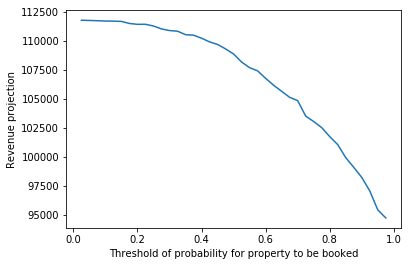

In [139]:
import matplotlib.pyplot as plt
plt.plot(revenue_by_threshold.index, revenue_by_threshold)
plt.ylabel('Revenue projection')
plt.xlabel('Threshold of probability for property to be booked')
plt.show()

Calculating percentage of change in expected revenue before and after tuning price using occupancy prediction model.

In [140]:
expected_revenue_original_price = 0
expected_revenue_modified_price = 0

for index, row in X_test.sample(n=1000, random_state=42).copy().iterrows():
    df = pd.DataFrame(data=row.to_dict(), index=[0])
    prob_booked = clf.predict_proba(df)[0][0]
    expected_revenue_original_price += prob_booked    * row["price_calendar"]
    
    revenue_at_tuned_price = calc_revenue_at_tuned_price(row, threshold_at_highest_revenue, clf)
    expected_revenue_modified_price += revenue_at_tuned_price

In [141]:
percentag_change = 100*(expected_revenue_modified_price - expected_revenue_original_price)/expected_revenue_original_price

In [142]:
percentag_change

8.729525101253397

## Keras

In [157]:
!pip install keras
!pip install tensorflow
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [167]:
def make_model(n_features, learn_rate):
    model = Sequential()

    model.add(Dense(150, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(75, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.10))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=learn_rate),
                  metrics=['acc'])

    return model

In [205]:
nn_model = make_model(len(X_train.drop(columns=["listing_id"]).columns), 0.01)

In [206]:
nn_model.fit(X_train.drop(columns=["listing_id"]), y_train.drop(columns=["listing_id"]), epochs=1)

Epoch 1/1
916150/916150 [==============================] - 200s 218us/step - loss: 0.6296 - acc: 0.6360


In [202]:
y_preds_nn = nn_model.predict(X_test)

In [207]:
nn_model.evaluate(x=X_test,y=y_test)

392740/392740 [==============================] - 28s 71us/step


[0.7273395635688923, 0.49317869328308805]

In [209]:
nn_model.metrics_names

['loss', 'acc']

In [203]:
f1 = f1_score(y_test, y_preds_nn, average="macro")
print ("f1-score: " + str(f1))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
y_train["available"].value_counts()/y_train.shape[0]

As we can see that the data available for classification is somewhat imbalanced. I am applying various approaches to ensure balance in the training received by the neural network based model.